In [ ]:
# Import Libraries
import time
start_time = time.time()

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

from mlxtend.frequent_patterns import apriori as ap1
from mlxtend.frequent_patterns import association_rules
!pip install apyori
from apyori import apriori as ap2

import matplotlib.pyplot as plt
import networkx as nx
!pip install pyspellchecker
from spellchecker import SpellChecker
from IPython.core import display as ICD

print("--- Executed in %.5s seconds ---" %(time.time() - start_time))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     |████████████████████████████████| 2.7MB 8.1MB/s 
--- Executed in 6.797 seconds ---


In [ ]:
start_time = time.time()
# Import 'online_retail.xlsx' From URL
url = r'https://raw.githubusercontent.com/QuanNguyenIU/Dataset/main/Online%20Retail.xlsx'
df = pd.read_excel(url)
# Remove non-transactions (dumps/refunds)
df = df[df.UnitPrice > 0]
df = df[df.Quantity > 0]
# Remove transactions with NULL Description
df = df[df.Description.notnull()]
# Remove transactions with non-purchase stock codes
df = df[~df.StockCode.isin(["B", "C2", "D", "m", "M", "S", "DOT", "POST"])]
df = df[~df.StockCode.isin(["AMAZONFEE", "BANK CHARGES", "CRUK", "PADS"])]
df = df[~df.StockCode.apply(str).str.contains("gift")]
# Replace special characters with ' '
df["Description"] = df["Description"].str.replace("/"," ")
df["Description"] = df["Description"].str.replace("&"," ")
df["Description"] = df["Description"].str.replace("+"," ")
# Re-enumerate indexes due to deleted transactions
df.reset_index(drop = True, inplace = True)
ICD.display(df)
print("--- Executed in %.5s seconds ---" %(time.time() - start_time))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
527753,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
527754,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
527755,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
527756,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


--- Executed in 57.75 seconds ---


**Part 1. Brief Summary**

In [ ]:
def extra_fields(dataframe):
    dataframe['TotalAmount'] = dataframe['Quantity'] * dataframe['UnitPrice']
    dataframe['InvoiceYear'] = dataframe['InvoiceDate'].dt.year
    dataframe['InvoiceMonth'] = dataframe['InvoiceDate'].dt.month

def sort_dataframe(dataframe, group, fsort):
    df_group = dataframe.groupby(group)
    result = df_group[fsort].agg(np.sum).sort_values(ascending = False)
    return result

def sort_unique_dataframe(dataframe, group, fsort):
    df_group = dataframe.groupby(group)
    uniques = df_group[fsort].unique()
    result = uniques.agg(np.size).sort_values(ascending = False)
    return result

def plot_bar(dataframe, head, df_title):
    dataframe.head(head).plot(kind = 'bar', title = df_title)
    plt.show()

def general_info(dataframe):
    print('Transaction Count: ',
          len(dataframe['InvoiceNo'].unique()))
    print('Anonymous Transaction Count: ',
          len(dataframe[dataframe['CustomerID'].isnull()]['InvoiceNo'
                                                          ].unique()))
    print('Customer Count: ', len(dataframe['CustomerID'].unique()) - 1)
    print('Total Profit: ', round(sum(dataframe['TotalAmount']), 2))
    top_customers = sort_dataframe(dataframe, 'CustomerID', 'TotalAmount')
    plot_bar(top_customers, 10, 'Top Customers by Total Amount')
    sort_quantity = sort_dataframe(dataframe, 'Description', 'Quantity')
    plot_bar(sort_quantity, 10, 'Frequent Items by Quantity')
    sort_amount = sort_dataframe(dataframe, 'Description', 'TotalAmount')
    plot_bar(sort_amount, 10, 'Frequent Items by Total Amount')

def explore_month(dataframe):
    df_month = dataframe.sort_values('InvoiceDate').groupby(['InvoiceYear',
                                                             'InvoiceMonth'])
    month_invoice = df_month['InvoiceNo'].unique().agg(np.size)
    plot_bar(month_invoice, 12, 'Invoice Count by Month')
    month_amount = df_month['TotalAmount'].agg(np.sum)
    plot_bar(month_amount, 12, 'Total Amount by Month')

def explore_country(dataframe):
    sort_amount = sort_dataframe(dataframe, 'Country', 'TotalAmount')
    plot_bar(sort_amount, 10, 'Countries by Total Amount')
    sort_invoice = sort_unique_dataframe(dataframe, 'Country', 'InvoiceNo')
    plot_bar(sort_invoice, 10, 'Countries by Invoice Count')
    sort_customer = sort_unique_dataframe(dataframe, 'Country', 'CustomerID')
    plot_bar(sort_customer, 10, 'Countries by Customer Count')

def brief_summary(dataframe):
    start_time = time.time()
    df_brief = dataframe
    extra_fields(df_brief)
    general_info(df_brief)
    explore_month(df_brief)
    explore_country(df_brief)
    print("--- Executed in %.5s seconds ---" %(time.time() - start_time))

Transaction Count:  19773
Anonymous Transaction Count:  1371
Customer Count:  4334
Total Profit:  10271433.06


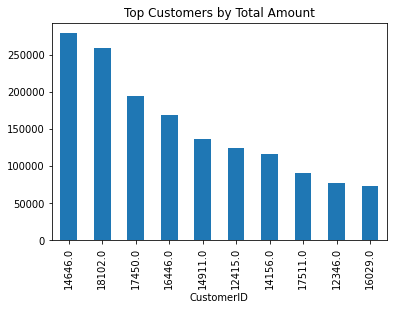

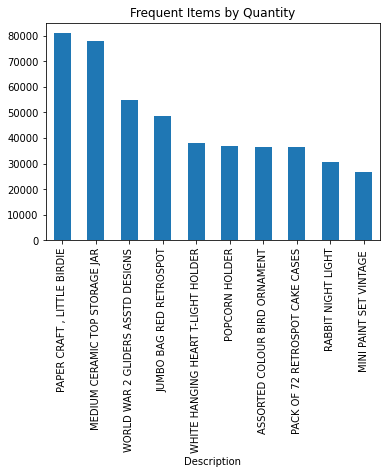

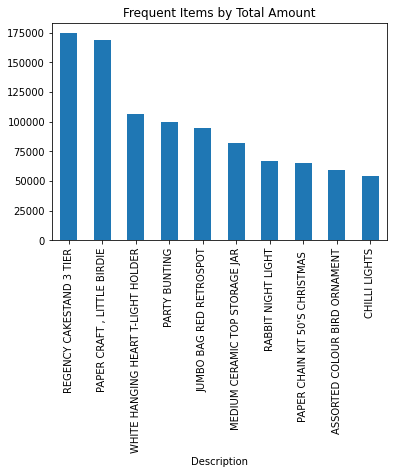

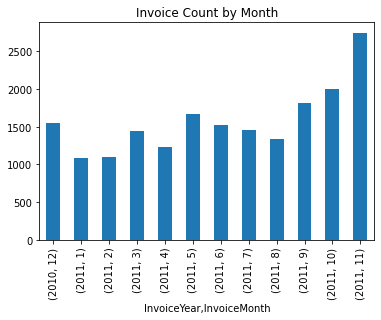

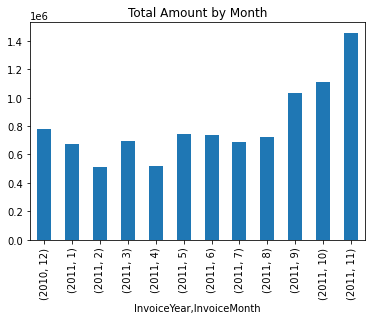

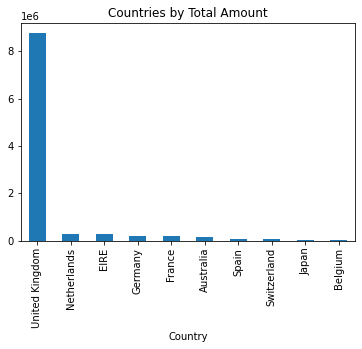

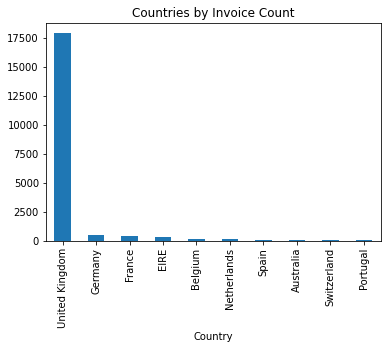

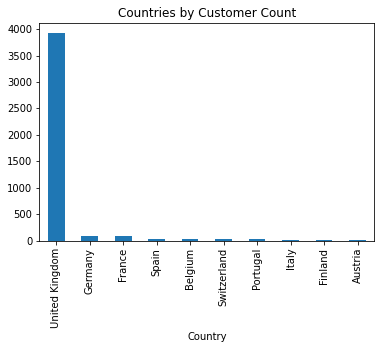

--- Executed in 2.191 seconds ---


In [ ]:
brief_summary(df)

**Part 2. Applying Apriori**

**2.1/ Apriori from *mlxtend* library:**



In [ ]:
def ap1_transform_data(df_original):
    invoice = ''
    transactions = []
    for index, value in enumerate(df_original['InvoiceNo']):
        if invoice != value:
            invoice = value
            transactions.append([df_original['Description'][index]])
            continue
        transactions[-1].append(df_original['Description'][index])
    df_transform = pd.DataFrame(transactions)
    df_transform.fillna(value = pd.np.nan, inplace = True)
    return df_transform

PUNCT = string.punctuation

def remove_punctuation(text):
	  return text.translate(str.maketrans('', '', PUNCT))

", ".join(stopwords.words('english'))
STOPW = set(stopwords.words('english'))

def remove_stopwords(text):
	  return " ".join([word for word in str(text
                                          ).split() if word not in STOPW])
def correct_spellings(text):
	corrected_text = []
	misspelled_words = spell.unknown(text.split())
	for word in text.split():
		if word in misspelled_words:
			corrected_text.append(spell.correction(word))
		else:
			corrected_text.append(word)
	return " ".join(corrected_text)

def preprocessing(dataframe):
    for column in dataframe:
        col = dataframe[column]
        col = col.astype(str)
        col = col.str.lower()
        col = col.apply(lambda text: remove_punctuation(text))
        col = col.apply(lambda text: remove_stopwords(text))
        dataframe[column] = col

def unique_items(dataframe):
    squeeze = dataframe.values.ravel()
    nan_items = pd.unique(squeeze)
    items = [x for x in nan_items if str(x) != 'nan']
    return items
    print(items)

def one_hot_encoding(dataframe, items):
    itemset = set(items)
    envals = []
    for idx, row in dataframe.iterrows():
	      rowset = set(row)
	      labels = {}
	      uncomms = list(itemset - rowset)
	      commons = list(itemset.intersection(rowset))
	      for uc in uncomms: labels[uc] = 0
	      for cm in commons: labels[cm] = 1
	      envals.append(labels)
    return envals

def ap1_plot(envals):
    ohedt = pd.DataFrame(envals)
    ICD.display(ohedt)
    fitems = ap1(ohedt, min_support = 0.01, use_colnames = True)
    fitems.sort_values('support', ascending = 0, inplace = True)
    fitems.reset_index(drop = True, inplace = True)
    ICD.display(fitems.head(10))
    rules = association_rules(fitems, metric = "confidence",
                              min_threshold = 0.02)
    rules.sort_values('support', ascending = 0, inplace = True)
    ICD.display(rules.head(10))
    plt.scatter(rules['support'], rules['confidence'],
                alpha = 0.5, marker = "*")
    plt.xlabel('support')
    plt.ylabel('confidence')
    plt.title('Support vs Confidence - Apriori from \'mlxtend\'')
    plt.show()
    return rules

def ap1_draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
    color_map = []
    N = 50
    colors = np.random.rand(N)
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5',
          'R6', 'R7', 'R8', 'R9', 'R10', 'R11']
    for i in range(rules_to_show):
        G1.add_nodes_from(["R" + str(i)])
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R" + str(i), color = colors[i] , weight = 1)
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R" + str(i), c, color = colors[i],  weight = 1)
    for node in G1:
        found_a_string = False
        for item in strs:
           if node == item: found_a_string = True
        if found_a_string: color_map.append('yellow')
        else: color_map.append('cyan')
    edgelist = G1.edges()
    edge_color = [G1[u][v]['color'] for u, v in edgelist]
    weights = [G1[u][v]['weight'] for u, v in edgelist]
    pos = nx.spring_layout(G1, k = 16, scale = 1)
    nx.draw(G1, pos, edgelist = edgelist, node_color = color_map,
            edge_color = edge_color, width = weights, font_size = 10,
            with_labels = True)
    plt.show()

def apriori_1(dataframe):
    start_time = time.time()
    df_transform = ap1_transform_data(dataframe)
    preprocessing(df_transform)
    items = unique_items(df_transform)
    envals = one_hot_encoding(df_transform, items)
    rules = ap1_plot(envals)
    ap1_draw_graph(rules, 10)
    print("--- Executed in %.5s seconds ---" % (time.time() - start_time))

,turq red boudicca large bracelet,greeting card overcrowded pool,baroque butterfly earrings red,hanging metal chicken decoration,strawberry shopper bag,sandalwood fan,photo frame 3 classic hanging,star wooden christmas decoration,set 12 colour pencils dolly girl,snack tray happy forest,blue sweetheart bracelet,jardin etched glass butter dish,hello sailor blue soap holder,3d christmas stamps stickers,red peony cushion cover,pink hearts light chain,standing fairy pole support,retro pill box key chainthe king,gin tonic diet greeting card,pompom curtain,dolly girl beaker,floor lamp shade wood base,french laundry sign blue metal,red retrospot big bowl,airline bag vintage jet set red,mirror mosaic candle plate,hanging bauble tlight holder small,rustic strawberry jampot large,picture frame wood triple portrait,apron apple delight,card cat tree,panda bunnies sticker sheet,kids cutlery spaceboy,cracked glaze necklace ivory,dog licence wall art,homemade jam scented candles,love building block word,happy birthday card stripey teddy,dinosaur lunch box cutlery,dolly girl lunch box,...,small licorice des pink bowl,blue shark helicopter,potting shed seed envelopes,hot water bottle babushka large,pocket bag pink paisely brown spot,wicker star,set 12 retro white chalk sticks,6 egg house painted wood,sweetheart carryall basket,necklace bracelet pink butterfly,dairy maid large milk jug,heart wreath decoration bell,beaded crystal heart green large,glass bead hoop necklace amethyst,apothecary measuring jar,retrospot red washing gloves,five cats hanging decoration,vintage red enamel trim jug,snack tray paisley park,office mug warmer choc blue,wrap pink flock,pastel blue photo album,vintage caravan greeting card,ocean scent candle jewelled box,acrylic jewel icicle pink,cake plate lovebird pink,ridged bonne jam jar tlight holder,cracked glaze earrings brown,childrens garden gloves blue,acrylic jewel snowflake pink,bag 125g swirly marbles,pink breakfast cup saucer,pink heart red handbag,set 7 babushka nesting boxes,knitted union flag hot water bottle,glass star frosted tlight holder,cream cupid hearts coat hanger,white hanging heart tlight holder,red woolly hottie white heart,white metal lantern
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19771,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

,support,itemsets
0,0.114095,(white hanging heart tlight holder)
1,0.105649,(jumbo bag red retrospot)
2,0.100541,(regency cakestand 3 tier)
3,0.085217,(party bunting)
4,0.079098,(lunch bag red retrospot)
5,0.073585,(assorted colour bird ornament)
6,0.070045,(set 3 cake tins pantry design)
7,0.066758,(pack 72 retrospot cake cases)
8,0.064937,(lunch bag suki design)
9,0.064381,(lunch bag black skull)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(jumbo bag red retrospot),(jumbo bag pink polkadot),0.105649,0.061599,0.041724,0.394926,6.411222,0.035216,1.550886
1,(jumbo bag pink polkadot),(jumbo bag red retrospot),0.061599,0.105649,0.041724,0.677340,6.411222,0.035216,2.771805
2,(roses regency teacup saucer),(green regency teacup saucer),0.053861,0.051231,0.038790,0.720188,14.057525,0.036031,3.390733
3,(green regency teacup saucer),(roses regency teacup saucer),0.051231,0.053861,0.038790,0.757157,14.057525,0.036031,3.896091
4,(jumbo bag red retrospot),(jumbo storage bag suki),0.105649,0.059880,0.036616,0.346577,5.787900,0.030289,1.438763
5,(jumbo storage bag suki),(jumbo bag red retrospot),0.059880,0.105649,0.036616,0.611486,5.787900,0.030289,2.301981
6,(jumbo bag red retrospot),(jumbo shopper vintage red paisley),0.105649,0.059424,0.034390,0.325515,5.477787,0.028112,1.394508
7,(jumbo shopper vintage red paisley),(jumbo bag red retrospot),0.059424,0.105649,0.034390,0.578723,5.477787,0.028112,2.122954
8,(lunch bag suki design),(lunch bag red retrospot),0.064937,0.079098,0.033075,0.509346,6.439447,0.027939,1.876886
9,(lunch bag red retrospot),(lunch bag suki design),0.079098,0.064937,0.033075,0.418159,6.439447,0.027939,1.607075


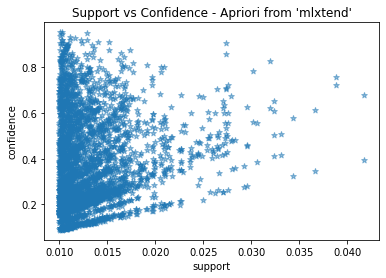

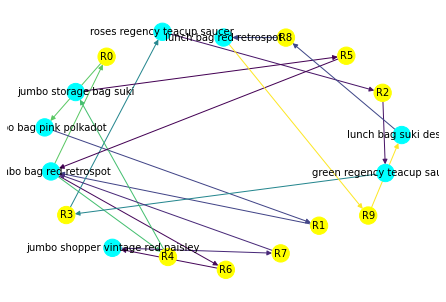

--- Executed in 211.2 seconds ---


In [ ]:
apriori_1(df)

**2.2/ Apriori from *apyori* library:**

In [ ]:
def ap2_transform_data(df_original):
    gp_invoiceno = df_original.groupby('InvoiceNo')
    transactions = []
    for name, group in gp_invoiceno:
        transactions.append(list(group['Description'].map(str)))
    return transactions

def ap2_plot(transactions):
    rules = ap2(transactions, min_support = 0.01,
                min_confidence = 0.2, min_length = 2)
    results = list(rules)
    tabular = pd.DataFrame(np.random.randint(low = 0, high = 1,
                                           size = (len(results), 6)),
                           columns = ['rules', 'antecedents',
                                      'consequents', 'support',
                                      'confidence', 'lift'])
    index = 0
    for g, s, i in results:
        tabular.iloc[index] = [' _&&_ '.join(list(g)),
                               ' _&&_ '.join(list(i[0][0])),
                               ' _&&_ '.join(list(i[0][1])),
                               s, i[0][2], i[0][3]]
        index = index + 1
    for column in ['rules', 'antecedents', 'consequents']:
        col = tabular[column]
        col = col.astype(str)
        col = col.str.lower()
        col.apply(lambda text: remove_punctuation(text))
        col.apply(lambda text: remove_stopwords(text))
        tabular[column] = col
    tabular.sort_values('support', ascending = 0, inplace = True)
    tabular.reset_index(drop = True, inplace = True)
    ICD.display(tabular.head(10))
    plt.scatter(tabular['support'], tabular['confidence'],
                alpha = 0.5, marker = "*")
    plt.xlabel('support')
    plt.ylabel('confidence')
    plt.title('Support vs Confidence - Apriori from \'apyori\'')
    plt.show()
    return tabular

def ap2_draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
    color_map = []
    N = 50
    colors = np.random.rand(N)
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5',
          'R6', 'R7', 'R8', 'R9', 'R10', 'R11']
    for i in range(rules_to_show):
        G1.add_nodes_from(["R" + str(i)])
        a, c = rules.at[i, 'antecedents'], rules.at[i, 'consequents']
        G1.add_nodes_from([a])
        G1.add_edge(a, "R" + str(i), color = colors[i] , weight = 1)
        G1.add_nodes_from([c])
        G1.add_edge("R" + str(i), c, color = colors[i],  weight = 1)
    for node in G1:
        found_a_string = False
        for item in strs:
           if node == item: found_a_string = True
        if found_a_string: color_map.append('yellow')
        else: color_map.append('cyan')
    edgelist = G1.edges()
    edge_color = [G1[u][v]['color'] for u, v in edgelist]
    weights = [G1[u][v]['weight'] for u, v in edgelist]
    pos = nx.spring_layout(G1, k = 16, scale = 1)
    nx.draw(G1, pos, edgelist = edgelist, node_color = color_map,
            edge_color = edge_color, width = weights, font_size = 10,
            with_labels = True)
    plt.show()

def apriori_2(dataframe):
    start_time = time.time()
    transactions = ap2_transform_data(dataframe)
    tabular = ap2_plot(transactions)
    ap2_draw_graph(tabular, 10)
    print("--- Executed in %.5s seconds ---" % (time.time() - start_time))

,rules,antecedents,consequents,support,confidence,lift
0,jumbo bag pink polkadot _&&_ jumbo bag red ret...,jumbo bag pink polkadot,jumbo bag red retrospot,0.041724,0.677340,6.411222
1,roses regency teacup and saucer _&&_ green re...,green regency teacup and saucer,roses regency teacup and saucer,0.038790,0.757157,14.057525
2,jumbo storage bag suki _&&_ jumbo bag red retr...,jumbo bag red retrospot,jumbo storage bag suki,0.036616,0.346577,5.787900
3,jumbo shopper vintage red paisley _&&_ jumbo b...,jumbo bag red retrospot,jumbo shopper vintage red paisley,0.034390,0.325515,5.477787
4,lunch bag black skull. _&&_ lunch bag red ret...,lunch bag black skull.,lunch bag red retrospot,0.032418,0.503535,6.365983
5,alarm clock bakelike red _&&_ alarm clock bak...,alarm clock bakelike green,alarm clock bakelike red,0.032367,0.653061,12.286374
6,pink regency teacup and saucer _&&_ green rege...,green regency teacup and saucer,pink regency teacup and saucer,0.031963,0.623889,16.125707
7,lunch bag pink polkadot _&&_ lunch bag red ret...,lunch bag pink polkadot,lunch bag red retrospot,0.030648,0.555963,7.028812
8,pink regency teacup and saucer _&&_ roses rege...,pink regency teacup and saucer,roses regency teacup and saucer,0.030243,0.781699,14.513184
9,jumbo bag baroque black white _&&_ jumbo bag ...,jumbo bag baroque black white,jumbo bag red retrospot,0.029586,0.627010,5.934831


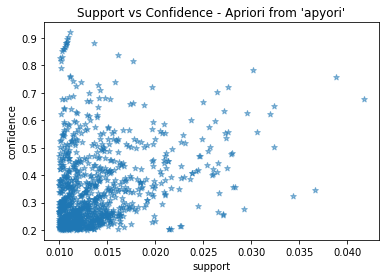

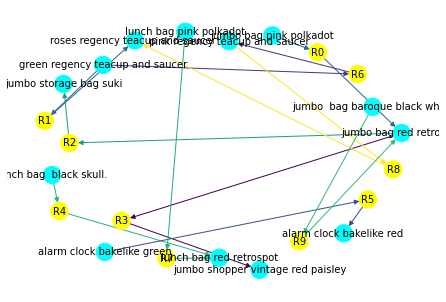

--- Executed in 20.24 seconds ---


In [ ]:
apriori_2(df)